#### Load the variables from .npy and libraries

In [1]:
import numpy as np

X_resized = np.load('X_resized_labelled.npy')
flattened_unlabelled_data = np.load('X_flattened_unlabelled.npy')

#### Perform Singular value decomposition (SVD)

In [2]:
U, S, Vt = np.linalg.svd(flattened_unlabelled_data, full_matrices=False)

For any real matrix $A \in \mathbb{R}^{n \times m}$, SVD breaks it down into three matrices:

$$
A = U \Sigma V^T
$$

Where:

* $U \in \mathbb{R}^{n \times n}$
* $\Sigma \in \mathbb{R}^{n \times m}$ (diagonal matrix)
* $V^T \in \mathbb{R}^{m \times m}$

But often we use the **reduced SVD** form:

$$
A \approx U_r \Sigma_r V_r^T \quad \text{where } r = \text{rank of } A
$$


#### What Each Matrix Represents

##### 1. **$U$: Left Singular Vectors**

* Columns of $U$ are **orthonormal eigenvectors** of $AA^T$. They represent directions in **input space** (rows of $A$)
* Geometrically, they define how to rotate/align data along new axes
* Size: $n \times r$

##### 2. **$\Sigma$: Singular Values**

* Diagonal matrix with **non-negative numbers** $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$
* Represents the **importance (energy/variance)** of each corresponding direction
* Large $\sigma_i$: More variance captured along that axis
* Size: $r \times r$ in reduced form

##### 3. **$V^T$: Right Singular Vectors**

* Rows of $V^T$ (or columns of $V$) are **orthonormal eigenvectors** of $A^T A$. They represent directions in **feature space** (columns of $A$)
* Used to project original features onto principal axes
* Size: $r \times m$



#### Why Do We Use SVD?

1. **Dimensionality Reduction** (like PCA):

   * Instead of using all components, we keep only the **top $r$** that capture most variance.
   * Helps with compression, noise removal, and visualization.



#### What Is the r Value?

* $r$ is the **effective rank** of the matrix $A$
* It’s the number of **non-zero singular values** in $\Sigma$
* It determines how many **principal components** (directions of variance) are needed

In [3]:
S

array([7.51081157e+05, 1.71357971e+05, 1.30429365e+05, ...,
       3.06916746e+02, 2.91423279e+02, 2.78846973e+02], shape=(4096,))

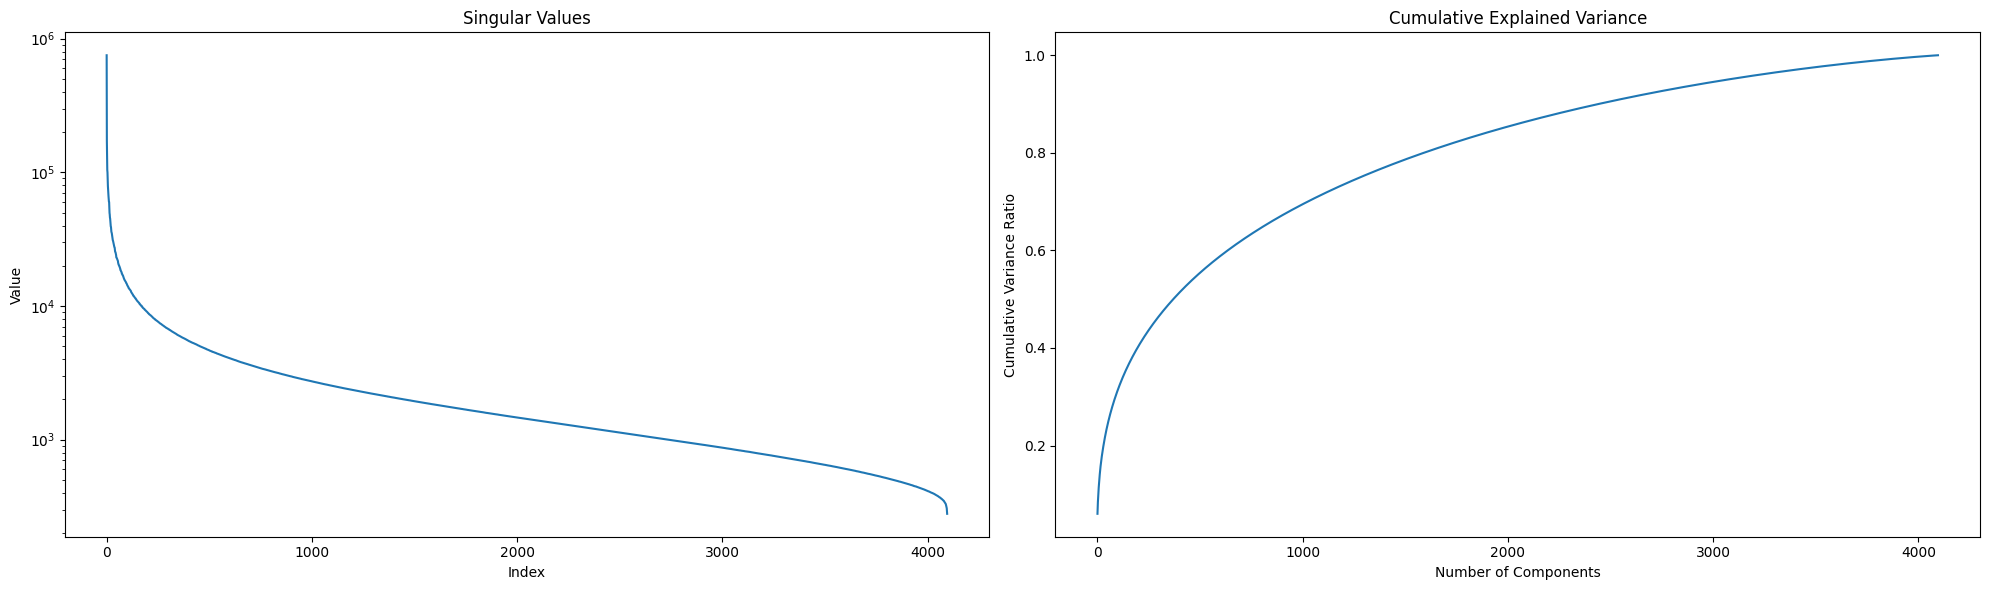

In [6]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(1, 2, figsize=(20, 6)) 
ax[0].semilogy(S)
ax[0].set_title('Singular Values')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Value')

ax[1].plot(np.cumsum(S) / np.sum(S))
ax[1].set_title('Cumulative Explained Variance')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Variance Ratio')

plt.tight_layout()
plt.show()

#### Determining the best r value using elbow plot (Knee locater)

Optimal r (elbow point) = 68


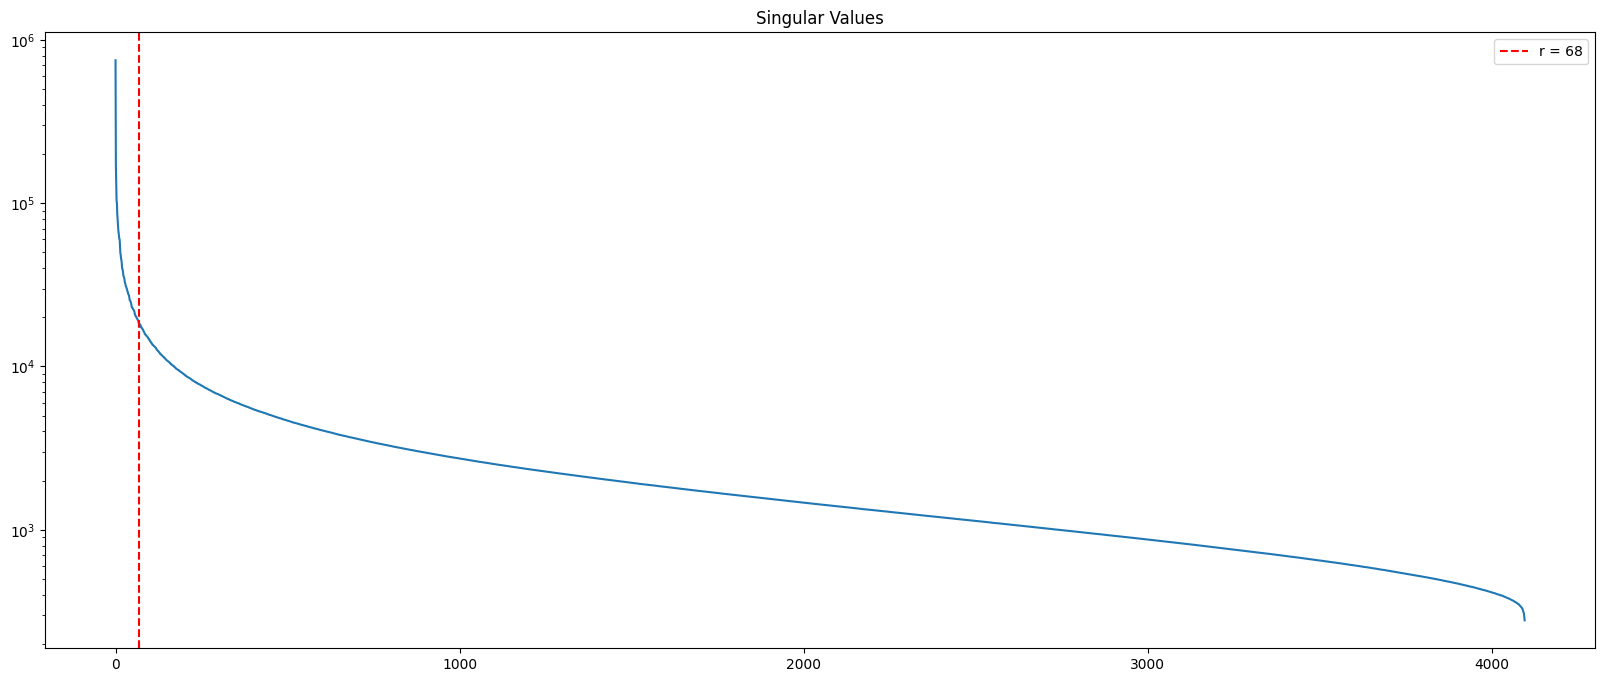

In [8]:
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt

S = np.array(S)  

plt.figure(figsize=(20,8))
plt.semilogy(S)
plt.title("Singular Values")

x = np.arange(1, len(S)+1)
knee = KneeLocator(x, S, curve='convex', direction='decreasing')
r = knee.knee

print(f"Optimal r (elbow point) = {r}")
plt.axvline(x=r, color='r', linestyle='--', label=f'r = {r}')
plt.legend()
plt.show()


#### Perform PCA for dimensionality reduction from 4096 dimensions (64 x 64) to r (68) dimensions 

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=r)    
pca.fit(flattened_unlabelled_data) 


PCA(n_components=np.int64(68))

- **Unlabeled data:** flattened_unlabelled_data  shape = (13233, 4096)
- **Labeled data:** X_resized shape = (920, 4096)

Number of components chosen = 68 (r value)

### Why do we fit PCA on the **unlabeled** data?

#### 1. PCA finds directions of maximum variance in the unlabled data.

* The unlabeled data is large and diverse (13233 images with different faces, poses, lighting, expressions)
* This rich variety helps PCA learn a **better, more general "face space"**

#### 2. Why not fit PCA on the labeled data directly?

* The labeled data (920 images) is smaller and less diverse.
* Fitting PCA only on it risks:
  * Capturing variance only in that small subset.
  * Missing important variations present in real faces.
* This can cause PCA components to fail to generalize well to new faces.

#### Step 1: Fit PCA on unlabeled data

```python
pca = PCA(n_components=68)
pca.fit(X_unlabeled)  
```

#### Step 2: Transform labeled data

```python
X_labeled_pca = pca.transform(X_labeled)  # Project labeled images onto those 68 components
```

* For each labeled image (a 4096D vector), this calculates its coordinates **in the 68D "face space"** PCA found.

#### Step 3: Train SVM on these transformed features

* Now the labeled data is smaller but expressed with **meaningful features** (68 components instead of 4096 raw pixels).
* SVM is trained on X_labeled_pca with labels emotion_labels.


* The labeled data benefits by being projected into this representation, making classification more reliable.
* Without the unlabeled data, PCA might miss important facial variations.



In [11]:
X_labeled_pca = pca.transform(X_resized)

In [12]:
X_labeled_pca

array([[ -396.30351961,   949.05126811,  -111.10470145, ...,
          -72.01108408,   117.7737912 ,   145.42827208],
       [ 2100.2590857 ,   474.72292936, -2320.16914501, ...,
          162.26672868,  -145.78696793,    87.08716607],
       [  404.83362337,   654.55451284, -1387.41077264, ...,
          162.35126075,   211.66275442,   180.8642226 ],
       ...,
       [ 2281.09301357,    52.3901259 , -1379.14776215, ...,
         -229.59332624,     2.88981557,    57.81009516],
       [ 1186.40968057,  1943.65353483, -1380.65018787, ...,
          -85.15218708,    45.26230009,  -139.25933572],
       [ 1912.90702008,  1185.72745327, -1888.17695122, ...,
          158.40084774,  -138.76097825,   283.80983815]], shape=(920, 68))

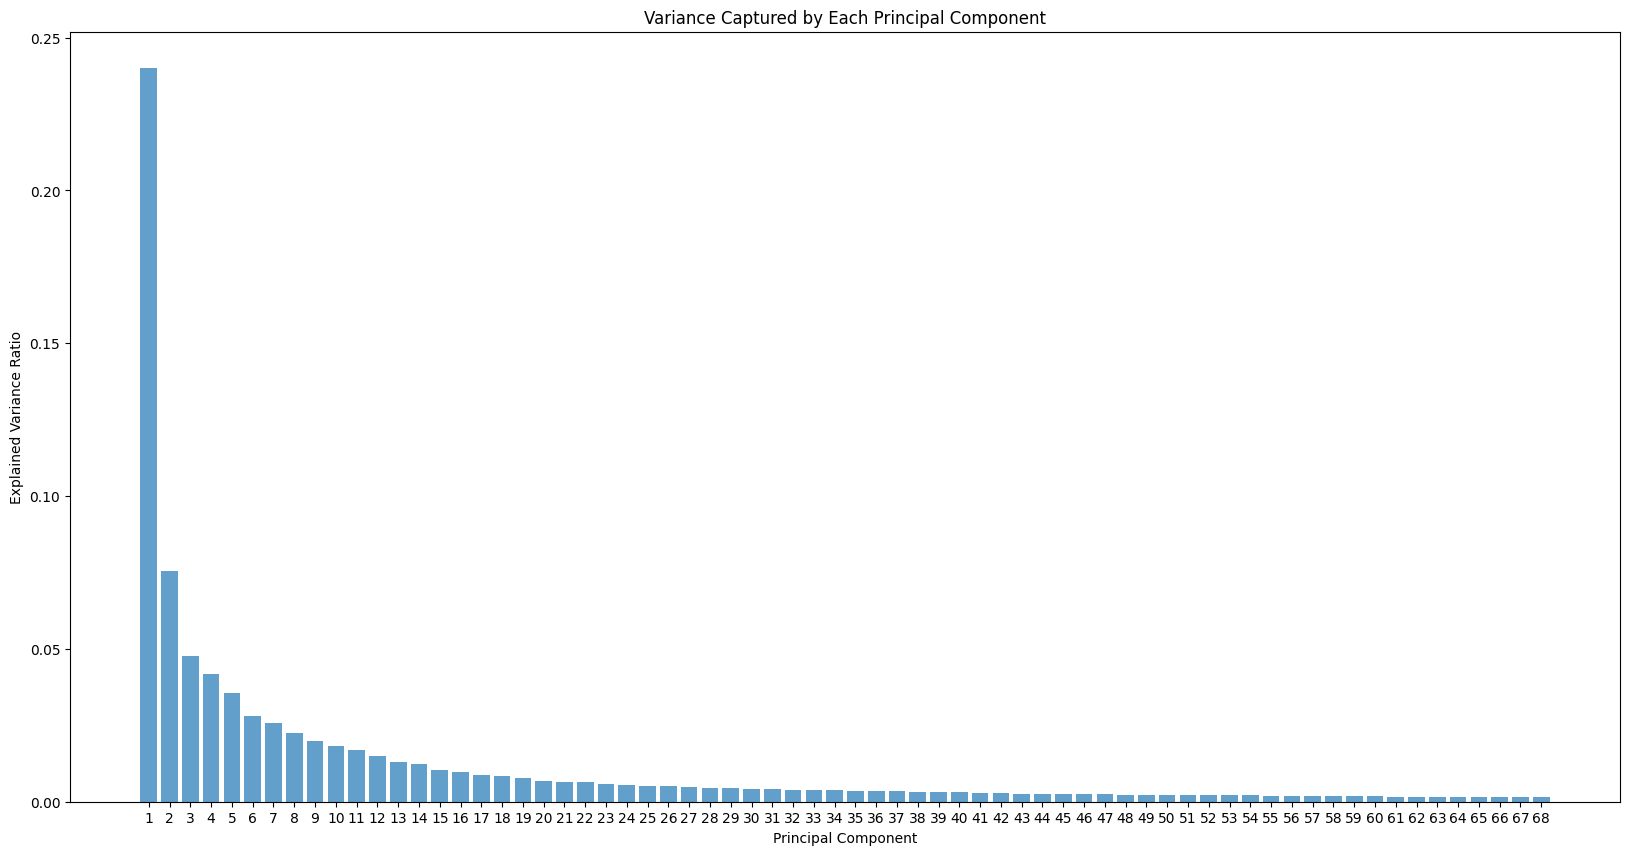

In [13]:
import matplotlib.pyplot as plt
import numpy as np

explained_variance = pca.explained_variance_ratio_  

plt.figure(figsize=(20, 10))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Captured by Each Principal Component')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

In [14]:
explained_variance

array([0.23994758, 0.07563537, 0.0477594 , 0.04184657, 0.03553363,
       0.02806779, 0.02582609, 0.02257962, 0.01980183, 0.01827876,
       0.0168134 , 0.01508105, 0.01288966, 0.0122315 , 0.01033201,
       0.00971021, 0.00860777, 0.00848614, 0.00776855, 0.00680417,
       0.00645176, 0.00631292, 0.00581729, 0.00540178, 0.00528141,
       0.00512868, 0.00485824, 0.00450917, 0.00440848, 0.00417551,
       0.00401312, 0.0039428 , 0.0038168 , 0.00373778, 0.00355789,
       0.00348086, 0.00335481, 0.00323478, 0.00316254, 0.00313337,
       0.00290883, 0.00274807, 0.00268941, 0.00267068, 0.00257488,
       0.00245763, 0.00240595, 0.00223473, 0.00220355, 0.00219824,
       0.00214937, 0.00211385, 0.00207246, 0.00205154, 0.0019881 ,
       0.00196051, 0.001842  , 0.00180497, 0.00173963, 0.00171526,
       0.00168901, 0.00167374, 0.00162464, 0.00160765, 0.00156132,
       0.00153727, 0.00151168, 0.00143172])

In [51]:
np.save('X_labelled_pca.npy', X_labeled_pca)